<a href="https://colab.research.google.com/github/bofeng2268/qm2/blob/main/analysis_plot_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install seaborn
!pip install matplotlib
!pip install esda
!pip install Pillow
!pip install geopandas libpysal mgwr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.8/331.8 kB 11.9 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import sqrt
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from scipy.stats import sem
import statistics
import seaborn as sns
from IPython.display import display, Math, Latex, display_latex
import plotly.express as px
import pylab
import pandas as pd
import numpy as np

In [3]:
#from example
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from statsmodels.formula.api import ols
from esda.moran import Moran
from libpysal.weights import Queen
import geopandas as gpd
import requests
import json
from prettytable import PrettyTable
from sklearn.preprocessing import StandardScaler
from statsmodels.iolib.summary2 import summary_col
import libpysal as ps
import geopandas as gpd
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

# Merging and Cleaning Data

In [4]:
#FILE PATHS
csv_file_path = 'https://raw.githubusercontent.com/bofeng2268/qm2/main/Phenomena/Local%20Authority%20Disability/TS038-2021-3-filtered-2024-01-01T16-28-10Z.csv'
topojson_file_path = 'https://raw.githubusercontent.com/bofeng2268/qm2/main/Phenomena/Local%20Authority%20Disability/topo_lad.json'
local_authorities_file_path = 'https://raw.githubusercontent.com/bofeng2268/qm2/main/Phenomena/Local%20Authority%20Disability/download6923730533685635445.csv'


In [5]:
#prepare the dataset for total disabled people density by regions
#link source:
total=pd.read_csv('https://raw.githubusercontent.com/bofeng2268/qm2/main/Phenomena/Local%20Authority%20Disability/TS038-2021-3-filtered-2024-01-01T16-28-10Z.csv')
eng_disability_data = total[total['Lower tier local authorities Code'].str.startswith('E')]
filtered_disability_data = eng_disability_data[eng_disability_data['Disability (5 categories) Code'].isin([1, 2])]
disabled = filtered_disability_data.groupby('Lower tier local authorities')['Observation'].sum().reset_index()


In [6]:
print(disabled)

    Lower tier local authorities  Observation
0                           Adur        12577
1                      Allerdale        19205
2                   Amber Valley        25066
3                           Arun        32481
4                       Ashfield        27809
..                           ...          ...
304                     Worthing        21303
305                     Wychavon        22955
306                         Wyre        24771
307                  Wyre Forest        20459
308                         York        34592

[309 rows x 2 columns]


Renaming Lower Tier Local Authorities

Bristol --> Bristol, City of

Herefordshire --> Herefordshire, County of

Kingston upon Hull --> Kingston upon Hull, City of

North Northamptonshire --> East Northamptonshire

West Northamptonshire --> South Northamptonshire

In [7]:

rename_map = {
    'Bristol': 'Bristol, City of',
    'Herefordshire': 'Herefordshire, County of',
    'Kingston upon Hull': 'Kingston upon Hull, City of',
    'North Northamptonshire': 'East Northamptonshire',
    'West Northamptonshire': 'South Northamptonshire'
}

disabled['Lower tier local authorities'] = disabled['Lower tier local authorities'].map(rename_map).fillna(disabled['Lower tier local authorities'])
print(disabled)

    Lower tier local authorities  Observation
0                           Adur        12577
1                      Allerdale        19205
2                   Amber Valley        25066
3                           Arun        32481
4                       Ashfield        27809
..                           ...          ...
304                     Worthing        21303
305                     Wychavon        22955
306                         Wyre        24771
307                  Wyre Forest        20459
308                         York        34592

[309 rows x 2 columns]


In [8]:
#prepare the blue badged population by regions
blue_badge = pd.read_csv('https://raw.githubusercontent.com/bofeng2268/qm2/main/BlueBadge/Blue_badges_held.csv', delimiter=';')
blue_badges_narrowed =  blue_badge[['Local Authority', 'Total valid Blue Badges held by organisations and individuals']]
filtered_blue_badges = blue_badges_narrowed[~blue_badges_narrowed['Local Authority'].str.contains('All')]

filtered_blue_badges.reset_index(drop=True, inplace=True)

filtered_blue_badges


,Local Authority,Total valid Blue Badges held by organisations and individuals
0,County Durham,27.884
1,Darlington,5.945
2,Hartlepool,5.530
3,Middlesbrough,6.546
4,Northumberland,16.242
...,...,...
153,Wiltshire,23.267
154,Devon,41.387
155,Dorset,25.370
156,Gloucestershire,28.348


In [9]:
#TIMES 1000

filtered_blue_badges['Total valid Blue Badges held by organisations and individuals'] = pd.to_numeric(filtered_blue_badges['Total valid Blue Badges held by organisations and individuals'], errors='coerce')



# Now, multiply by 1000 and convert to integer
filtered_blue_badges['Total valid Blue Badges held by organisations and individuals'] = (filtered_blue_badges['Total valid Blue Badges held by organisations and individuals'] * 1000).astype(int)

filtered_blue_badges

<ipython-input-9-b6bf927cb0af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_blue_badges['Total valid Blue Badges held by organisations and individuals'] = pd.to_numeric(filtered_blue_badges['Total valid Blue Badges held by organisations and individuals'], errors='coerce')
<ipython-input-9-b6bf927cb0af>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_blue_badges['Total valid Blue Badges held by organisations and individuals'] = (filtered_blue_badges['Total valid Blue Badges held by or

,Local Authority,Total valid Blue Badges held by organisations and individuals
0,County Durham,27884
1,Darlington,5945
2,Hartlepool,5530
3,Middlesbrough,6546
4,Northumberland,16242
...,...,...
153,Wiltshire,23267
154,Devon,41387
155,Dorset,25370
156,Gloucestershire,28348


In [10]:
#RENAME

In [11]:
rename_map = {
    'North Northamptonshire': 'East Northamptonshire',
    'West Northamptonshire': 'South Northamptonshire',
    'Cambridgeshire': 'East Cambridgeshire',
    'Hampshire': 'East Hampshire',
    'Derbyshire': 'Derbyshire Dales',
    'Lancashire': 'West Lancashire',
    'Lincolnshire': 'Lincoln',
    'Somerset': 'South Somerset',
    'Surrey': 'Surrey Heath',
    'Warwickshire': 'North Warwickshire',
    'Leicestershire': 'North West Leicestershire'}

filtered_blue_badges['Local Authority'] = filtered_blue_badges['Local Authority'].map(rename_map).fillna(filtered_blue_badges['Local Authority'])
filtered_blue_badges

<ipython-input-11-faa3ae397a8c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_blue_badges['Local Authority'] = filtered_blue_badges['Local Authority'].map(rename_map).fillna(filtered_blue_badges['Local Authority'])


,Local Authority,Total valid Blue Badges held by organisations and individuals
0,County Durham,27884
1,Darlington,5945
2,Hartlepool,5530
3,Middlesbrough,6546
4,Northumberland,16242
...,...,...
153,Wiltshire,23267
154,Devon,41387
155,Dorset,25370
156,Gloucestershire,28348


In [12]:
# Function to do the division and create new local authorities
def divide_and_create_local_authorities(df, original_la, new_local_authorities, division_factor):
    if original_la in df['Local Authority'].values:
        original_value = df[df['Local Authority'] == original_la]['Total valid Blue Badges held by organisations and individuals'].iloc[0]
        divided_value = original_value / division_factor

        # Creating new rows for the new local authorities
        for la in new_local_authorities:
            new_row = {'Local Authority': la, 'Total valid Blue Badges held by organisations and individuals': divided_value}
            df = df.append(new_row, ignore_index=True)

        # Remove the original local authority row
        df = df[df['Local Authority'] != original_la]

    return df


# Step 1 - Essex
new_local_authorities_essex = ['Braintree', 'Castle Point', 'Chelmsford', 'Colchester', 'Harlow', 'Maldon', 'Rochford', 'Uttlesford']
filtered_blue_badges = divide_and_create_local_authorities(filtered_blue_badges, 'Essex', new_local_authorities_essex, 8)


filtered_blue_badges


# Step 2 (Worcestershire
new_local_authorities_worcestershire = ['Bromsgrove', 'Malvern Hills', 'Redditch', 'Worcester', 'Wychavon', 'Wyre Forest']
filtered_blue_badges = divide_and_create_local_authorities(filtered_blue_badges, 'Worcestershire', new_local_authorities_worcestershire, 6)

filtered_blue_badges



<ipython-input-12-547bf8e21468>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-12-547bf8e21468>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-12-547bf8e21468>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-12-547bf8e21468>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-12-547bf8e21468>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Us

,Local Authority,Total valid Blue Badges held by organisations and individuals
0,County Durham,27884.000000
1,Darlington,5945.000000
2,Hartlepool,5530.000000
3,Middlesbrough,6546.000000
4,Northumberland,16242.000000
...,...,...
166,Malvern Hills,5511.166667
167,Redditch,5511.166667
168,Worcester,5511.166667
169,Wychavon,5511.166667


XXXXXX Those don't work (eg. you can still find Hertfordshire when you run the df it doesn't get deleted and the new local authorities that should be added to the df (with the new mean value) don't show) -

-> in fact, the rows of the df are inconsistent (go from 158 -> 170)
 Bea to fix  XXXXXXXX

```
# Hertfordshire
new_local_authorities_hertfordshire = ['North Hertfordshire', 'South Hertfordshire']
filtered_blue_badges = divide_and_create_local_authorities(filtered_blue_badges, 'Hertfordshire', new_local_authorities_hertfordshire, 2)

# Norfolk
new_local_authorities_norfolk = ["King's Lynn and West Norfolk", 'South Norfolk', 'North Norfolk']
filtered_blue_badges = divide_and_create_local_authorities(filtered_blue_badges, 'Norfolk', new_local_authorities_norfolk, 3)

# Oxfordshire
new_local_authorities_oxfordshire = ['South Oxfordshire', 'West Oxfordshire']
filtered_blue_badges = divide_and_create_local_authorities(filtered_blue_badges, 'Oxfordshire', new_local_authorities_oxfordshire, 2)```



In [13]:
#merge the two datasets
merged_data = pd.merge(filtered_blue_badges, disabled, left_on='Local Authority', right_on='Lower tier local authorities', how='inner')


# Convert columns to numeric
merged_data['Total valid Blue Badges held by organisations and individuals'] = pd.to_numeric(merged_data['Total valid Blue Badges held by organisations and individuals'])
merged_data['Observation'] = pd.to_numeric(merged_data['Observation'])
merged_data

,Local Authority,Total valid Blue Badges held by organisations and individuals,Lower tier local authorities,Observation
0,County Durham,27884.000000,County Durham,119790
1,Darlington,5945.000000,Darlington,21104
2,Hartlepool,5530.000000,Hartlepool,21145
3,Middlesbrough,6546.000000,Middlesbrough,29520
4,Northumberland,16242.000000,Northumberland,67190
...,...,...,...,...
126,Malvern Hills,5511.166667,Malvern Hills,15144
127,Redditch,5511.166667,Redditch,15304
128,Worcester,5511.166667,Worcester,18195
129,Wychavon,5511.166667,Wychavon,22955


In [14]:
#Transport Reliant People
# Convert columns to numeric
merged_data['Total valid Blue Badges held by organisations and individuals'] = pd.to_numeric( merged_data['Total valid Blue Badges held by organisations and individuals'])
merged_data['Observation'] = pd.to_numeric( merged_data['Observation'])

# Create the new column by subtracting the two columns
merged_data['Transport reliant people with a disability estimate'] =  merged_data['Observation'] -  merged_data['Total valid Blue Badges held by organisations and individuals']
merged_data



,Local Authority,Total valid Blue Badges held by organisations and individuals,Lower tier local authorities,Observation,Transport reliant people with a disability estimate
0,County Durham,27884.000000,County Durham,119790,91906.000000
1,Darlington,5945.000000,Darlington,21104,15159.000000
2,Hartlepool,5530.000000,Hartlepool,21145,15615.000000
3,Middlesbrough,6546.000000,Middlesbrough,29520,22974.000000
4,Northumberland,16242.000000,Northumberland,67190,50948.000000
...,...,...,...,...,...
126,Malvern Hills,5511.166667,Malvern Hills,15144,9632.833333
127,Redditch,5511.166667,Redditch,15304,9792.833333
128,Worcester,5511.166667,Worcester,18195,12683.833333
129,Wychavon,5511.166667,Wychavon,22955,17443.833333


In [15]:
#GET RID OF CITY OF LONDON - INACCURATE DATA POINT (provide Justification in analysis)
merged_data = merged_data[merged_data['Local Authority'] != 'City of London']
merged_data = merged_data.drop(['Lower tier local authorities'],axis=1)
merged_data.rename(columns={'Observation': 'Disable_population'}, inplace=True)
merged_data.rename(columns={'Total valid Blue Badges held by organisations and individuals': 'Blue_Badges_population'}, inplace=True)
merged_data.rename(columns={'Transport reliant people with a disability estimate': 'Transport_reliant_population'}, inplace=True)


merged_data

,Local Authority,Blue_Badges_population,Disable_population,Transport_reliant_population
0,County Durham,27884.000000,119790,91906.000000
1,Darlington,5945.000000,21104,15159.000000
2,Hartlepool,5530.000000,21145,15615.000000
3,Middlesbrough,6546.000000,29520,22974.000000
4,Northumberland,16242.000000,67190,50948.000000
...,...,...,...,...
126,Malvern Hills,5511.166667,15144,9632.833333
127,Redditch,5511.166667,15304,9792.833333
128,Worcester,5511.166667,18195,12683.833333
129,Wychavon,5511.166667,22955,17443.833333


#Summary Statistics

In [16]:
summary=merged_data.describe().round(2)  # generate summary statistics, and round everything to 2 decimal degrees
summary=summary.T #.T transposes the table (rows become columns and vice versa)
summary

,count,mean,std,min,25%,50%,75%,max
Blue_Badges_population,130.0,12864.55,10055.99,2442.0,7250.75,9541.0,14215.75,62975.0
Disable_population,130.0,42266.50,26004.32,294.0,26213.00,36892.0,53468.50,198064.0
Transport_reliant_population,130.0,29401.95,25003.86,-40706.0,19821.00,27309.5,40206.50,158004.0


In [17]:
# Setup the PrettyTable
table = PrettyTable()
table.field_names = ["Variable", "Mean", "St. Dev.", "Min", "25%", "50%", "75%", "Max"]
table.title = "Summary Statistics"

# Add data to the table
for row in summary.iterrows():
    table.add_row([row[0], row[1]["mean"], row[1]["std"], row[1]["min"], row[1]["25%"], row[1]["50%"], row[1]["75%"], row[1]["max"]])

# Print the table
print(table)

+---------------------------------------------------------------------------------------------------------+
|                                            Summary Statistics                                           |
+------------------------------+----------+----------+----------+---------+---------+----------+----------+
|           Variable           |   Mean   | St. Dev. |   Min    |   25%   |   50%   |   75%    |   Max    |
+------------------------------+----------+----------+----------+---------+---------+----------+----------+
|    Blue_Badges_population    | 12864.55 | 10055.99 |  2442.0  | 7250.75 |  9541.0 | 14215.75 | 62975.0  |
|      Disable_population      | 42266.5  | 26004.32 |  294.0   | 26213.0 | 36892.0 | 53468.5  | 198064.0 |
| Transport_reliant_population | 29401.95 | 25003.86 | -40706.0 | 19821.0 | 27309.5 | 40206.5  | 158004.0 |
+------------------------------+----------+----------+----------+---------+---------+----------+----------+


# Outliers

In [18]:

def filter_outliers(var):
    Q1 = var.quantile(0.25) # calculate the first quartile
    Q3 = var.quantile(0.75) # calculate the third quartile
    IQR = Q3 - Q1 # calculate the interquartile range
    LOWBOUND = Q1 - 3*IQR # calculate the lower bound
    HIGHBOUND = Q3 + 3*IQR # calculate the upper bound
    filtered = merged_data[(var > LOWBOUND) & (var < HIGHBOUND)] # filter  the values that are within the bounds
    dropped_observations= len(var)-len(filtered) # calculate the number of observations that were dropped

    print('Dropped {} observations'.format(dropped_observations))
    return  filtered

#Filter outliers
reg_df=filter_outliers(merged_data['Blue_Badges_population'])
reg_df=filter_outliers(merged_data['Disable_population'])
reg_df=filter_outliers(merged_data['Transport_reliant_population'])



Dropped 6 observations
Dropped 1 observations
Dropped 1 observations


In [19]:
# Create an instance of PrettyTable
table = PrettyTable()

# Define the column names
table.field_names = ["Variable", "Observations Dropped"]

# Add rows to the table with the data
table.add_row(["Blue_Badges_population", 6])
table.add_row(["Disable_population", 1])
table.add_row(["Transport_reliant_population", 2])


# Print the table
print(table)

+------------------------------+----------------------+
|           Variable           | Observations Dropped |
+------------------------------+----------------------+
|    Blue_Badges_population    |          6           |
|      Disable_population      |          1           |
| Transport_reliant_population |          2           |
+------------------------------+----------------------+


#Box Plots

In [20]:
#Variables
x = merged_data[['Blue_Badges_population']]
y = merged_data[['Disable_population']]
z = merged_data[['Transport_reliant_population']]

In [21]:
# Create the Box Plot
import plotly.express as px

fig = px.box(merged_data, y='Disable_population', title= 'Disabled Population, England 2022')

fig.show()

In [22]:
# Create the Box Plot
import plotly.express as px

fig = px.box(merged_data, y='Blue_Badges_population', title= 'Box Plot of Blue Badges Held per Local Authority, England 2022')

fig.show()

In [23]:
# Create the Box Plot
import plotly.express as px

fig = px.box(merged_data, y='Transport_reliant_population', title= 'Box Plot of Estimate Transport Reliant People with a Disability Population per Local Authority, England 2022')

fig.show()

# Histogram


## Disabled Population

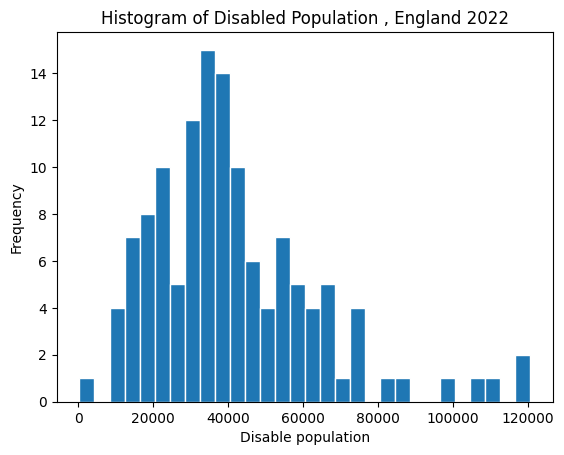

In [24]:
plt.hist(reg_df['Disable_population'], bins=30, edgecolor='white', density=False)

plt.ylabel('Frequency')
plt.xlabel('Disable population') # add a label to the x axis
plt.title("Histogram of Disabled Population , England 2022")
plt.show()

## Transport Reliant Population

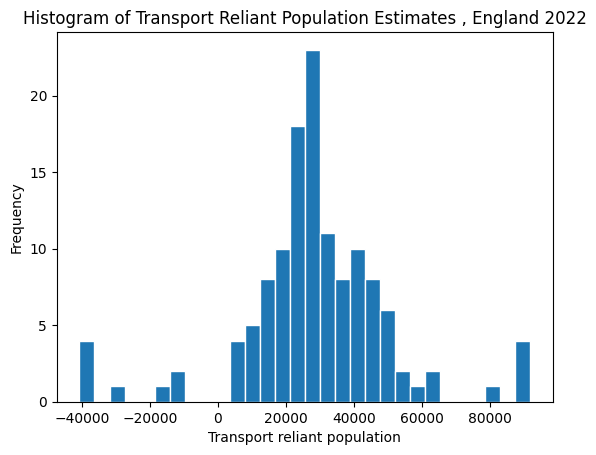

In [25]:
plt.hist(reg_df['Transport_reliant_population'], bins=30, edgecolor='white', density=False)

plt.ylabel('Frequency')
plt.xlabel('Transport reliant population') # add a label to the x axis
plt.title("Histogram of Transport Reliant Population Estimates , England 2022")
plt.show()

## Blue Badges Held

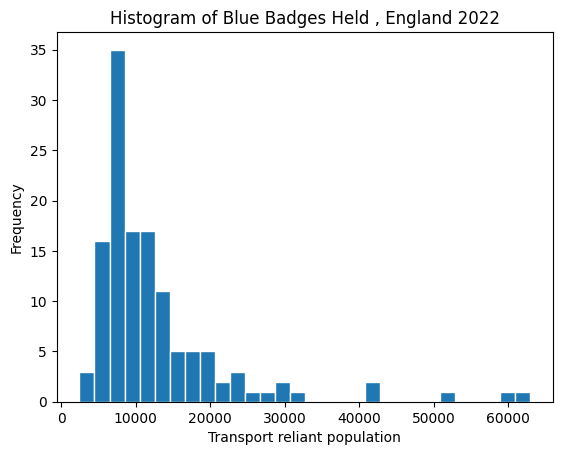

In [26]:
plt.hist(reg_df['Blue_Badges_population'], bins=30, edgecolor='white', density=False)

plt.ylabel('Frequency')
plt.xlabel('Transport reliant population') # add a label to the x axis
plt.title("Histogram of Blue Badges Held , England 2022")
plt.show()

# Simple Regression Analysis

# Transport Reliant Population VS Total Disabled Population per Local Authority

Text(0.5, 1.0, 'Transport Reliant Population VS Total Disabled Population Scatterplot')

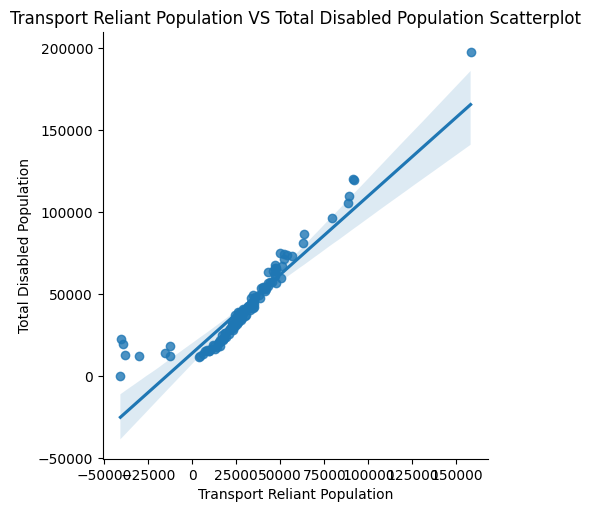

In [27]:
# Generate the scatter plot
sns.lmplot(x='Transport_reliant_population', y='Disable_population', data= merged_data)

plt.xlabel('Transport Reliant Population')
plt.ylabel('Total Disabled Population')

# Display the plot
plt.title("Transport Reliant Population VS Total Disabled Population Scatterplot")

### ❌ LONELINESS or DEPRIVATION FACTOR VS BLUE BADGES HELD (look at the end for the plan of next steps)

# OLS Regression


## New section

### Homoscedasticity test - Breusch-Pagan test

In [28]:
def homoscedasticity_test(lm_results):
    print(lm_results.summary())

    # Perform the Breusch-Pagan test
    bp_test = het_breuschpagan(lm_results.resid, lm_results.model.exog)

    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    print("\nBreusch-Pagan test for homoscedasticity:")
    homoscedasticity = False
    for label, value in zip(labels, bp_test):
        print(f"{label}: {value}")
        if label == "F-Test p-value":
            if value > 0.05:
                homoscedasticity = True
    if homoscedasticity:
        print("The regression convey homoscedasticity")
    else:
        print("The regression does not convey homoscedasticity")

Text(87.72222222222221, 0.5, 'Transport Reliant population')

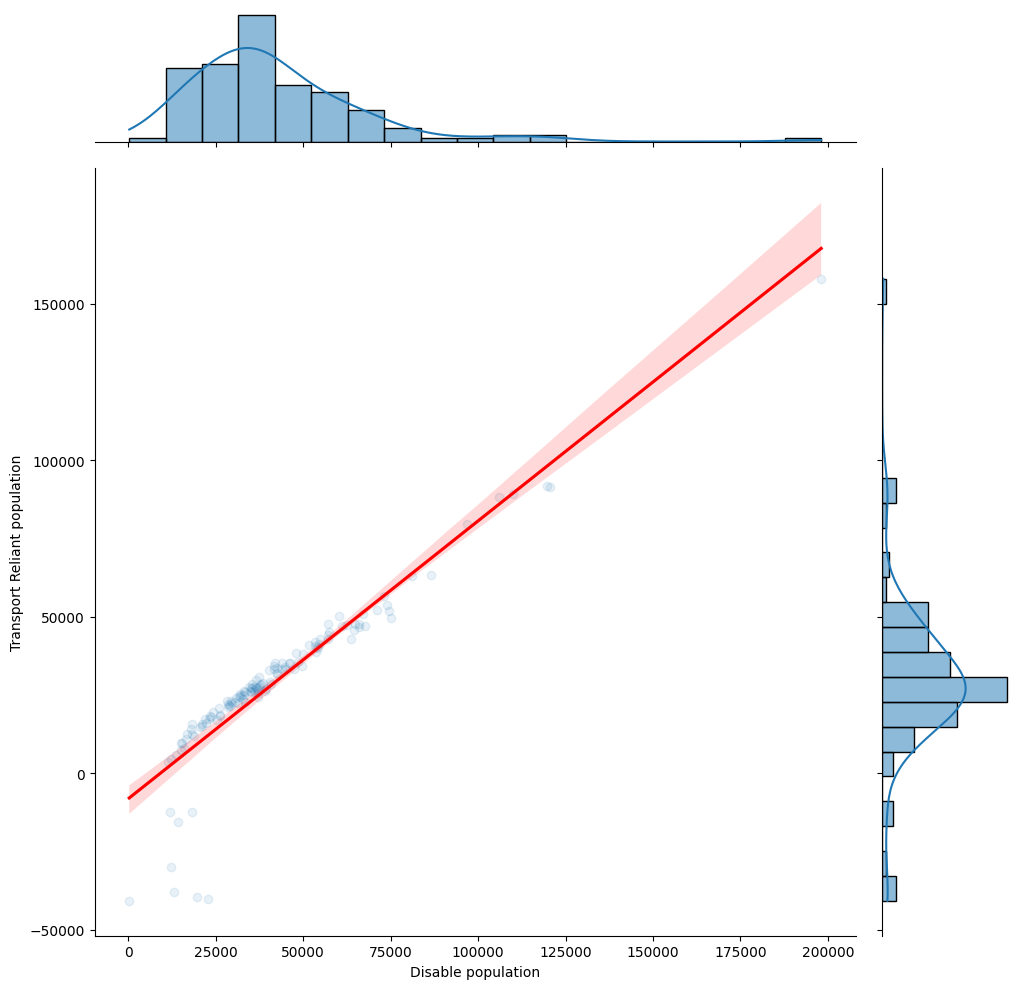

In [29]:
#Homoscedasticity
sns.jointplot(data=merged_data, # plot a scatterplot with a regression line and two histograms
                x='Disable_population', # set the x axis to be the years of schooling
                y='Transport_reliant_population', # set the y axis to be the hourly wage
                kind="reg",  # set the kind of plot to be a regression plot
                scatter_kws=dict(alpha=0.1), # set the transparency of the points to be 0.1 (10%)
                line_kws=dict(color='red'), # set the color of the regression line to red
                height=10) # set the height of the plot to be 10 inches

plt.xlabel('Disable population') # add a label to the x axis
plt.ylabel('Transport Reliant population') # add a label to the y axis

In [30]:
from statsmodels.formula.api import ols #the function
from statsmodels.iolib.summary2 import summary_col #to produce a very nice table

model= ols('Transport_reliant_population ~  Disable_population', data=reg_df).fit() # fit the model
print(model.summary()) # print the summary

                                 OLS Regression Results                                 
Dep. Variable:     Transport_reliant_population   R-squared:                       0.815
Model:                                      OLS   Adj. R-squared:                  0.814
Method:                           Least Squares   F-statistic:                     561.1
Date:                          Fri, 12 Jan 2024   Prob (F-statistic):           1.97e-48
Time:                                  22:46:32   Log-Likelihood:                -1365.5
No. Observations:                           129   AIC:                             2735.
Df Residuals:                               127   BIC:                             2741.
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

In [ ]:
import statsmodels.formula.api as smf
from scipy import stats
# Fit a linear regression model and store the results in lm_results_1
lm_results_1 = smf.ols('Transport_reliant_population ~  Disable_population', data=overall_data_scaled).fit()

homoscedasticity_test(lm_results_1)

In [ ]:
from tabulate import tabulate

# Assign the actual LM test results to variables
lm_statistic = 4.947847597611243
lm_pvalue = 0.02612317219835892

# Define the data for the table
bp_lm_test_data = [
    ["Test Statistic", lm_statistic],
    ["p-value", lm_pvalue]
]

# Create the table using tabulate
bp_lm_test_table = tabulate(bp_lm_test_data, headers=["Test", "Value"], tablefmt="pretty")

# Print the table
print("Results of the Breusch-Pagan LM Test")
print(bp_lm_test_table)

# NEXT STEPS (to do by Saturday 13th night - so we have time to do analysis)
- Bivariate choropleth Map: Transport Reliant VS Disable_population
- add Deprivation Factor (https://www.gov.uk/government/statistics/english-indices-of-deprivation-2019) variable OR loneliness (Data for loneliness:  
https://www.ons.gov.uk/peoplepopulationandcommunity/healthandsocialcare/disability/datasets/disabilityandloneliness)
  - repeat all process done so far
  - do Trivariant choropleth map / or Bubble Map: add deprivation factor as bubbles on the Bivariate choropleth map
- for all models: regression diagnostics
  - multi collinearity
  - normality
  - homoscedasticity
- Geographic weighted regression: Reference: https://deepnote.com/@carlos-mendez/PYTHON-GWR-and-MGWR-71dd8ba9-a3ea-4d28-9b20-41cc8a282b7a
  - regression

- extra: london voronoi diagrams (if we have time)

